# Self Organizing Maps 3

Use self organizing maps to group representatives of Swedish political parties based on their stances on certain political issues. Also investigates to what extent district and gender influence voting patterns.

In [1]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)

from ann.plotting import figsize, subplots
from ann.som import som

In [2]:
votes = np.genfromtxt('../data/votes.dat', delimiter=',').reshape(349, 31)

party = np.genfromtxt('../data/mpparty.dat', comments='%', dtype=np.uint8)
district = np.genfromtxt('../data/mpdistrict.dat', comments='%', dtype=np.uint8)
sex = np.genfromtxt('../data/mpsex.dat', comments='%', dtype=np.uint8)

mp_attrs = np.column_stack((party, district, sex))

mp_attr_names = ["Party", "District", "Sex"]

mp_val_names = [
    [
        "No Party",
        "The Moderate Party",
        "Liberal People's Party",
        "The Social Democrats",
        "The Left Party",
        "The Greens",
        "Christian Democrats",
        "Centre Party"
    ],
    [None] + [
        "District {}".format(d) for d in np.unique(district)
    ],
    [
        "Male",
        "Female"
    ]
]

In [3]:
gridsize = (10, 10)

scores, _, _ = som(votes,
                   outputs=gridsize,
                   neighbourhood='grid',
                   neighbourhood_init=4,
                   epochs=5)

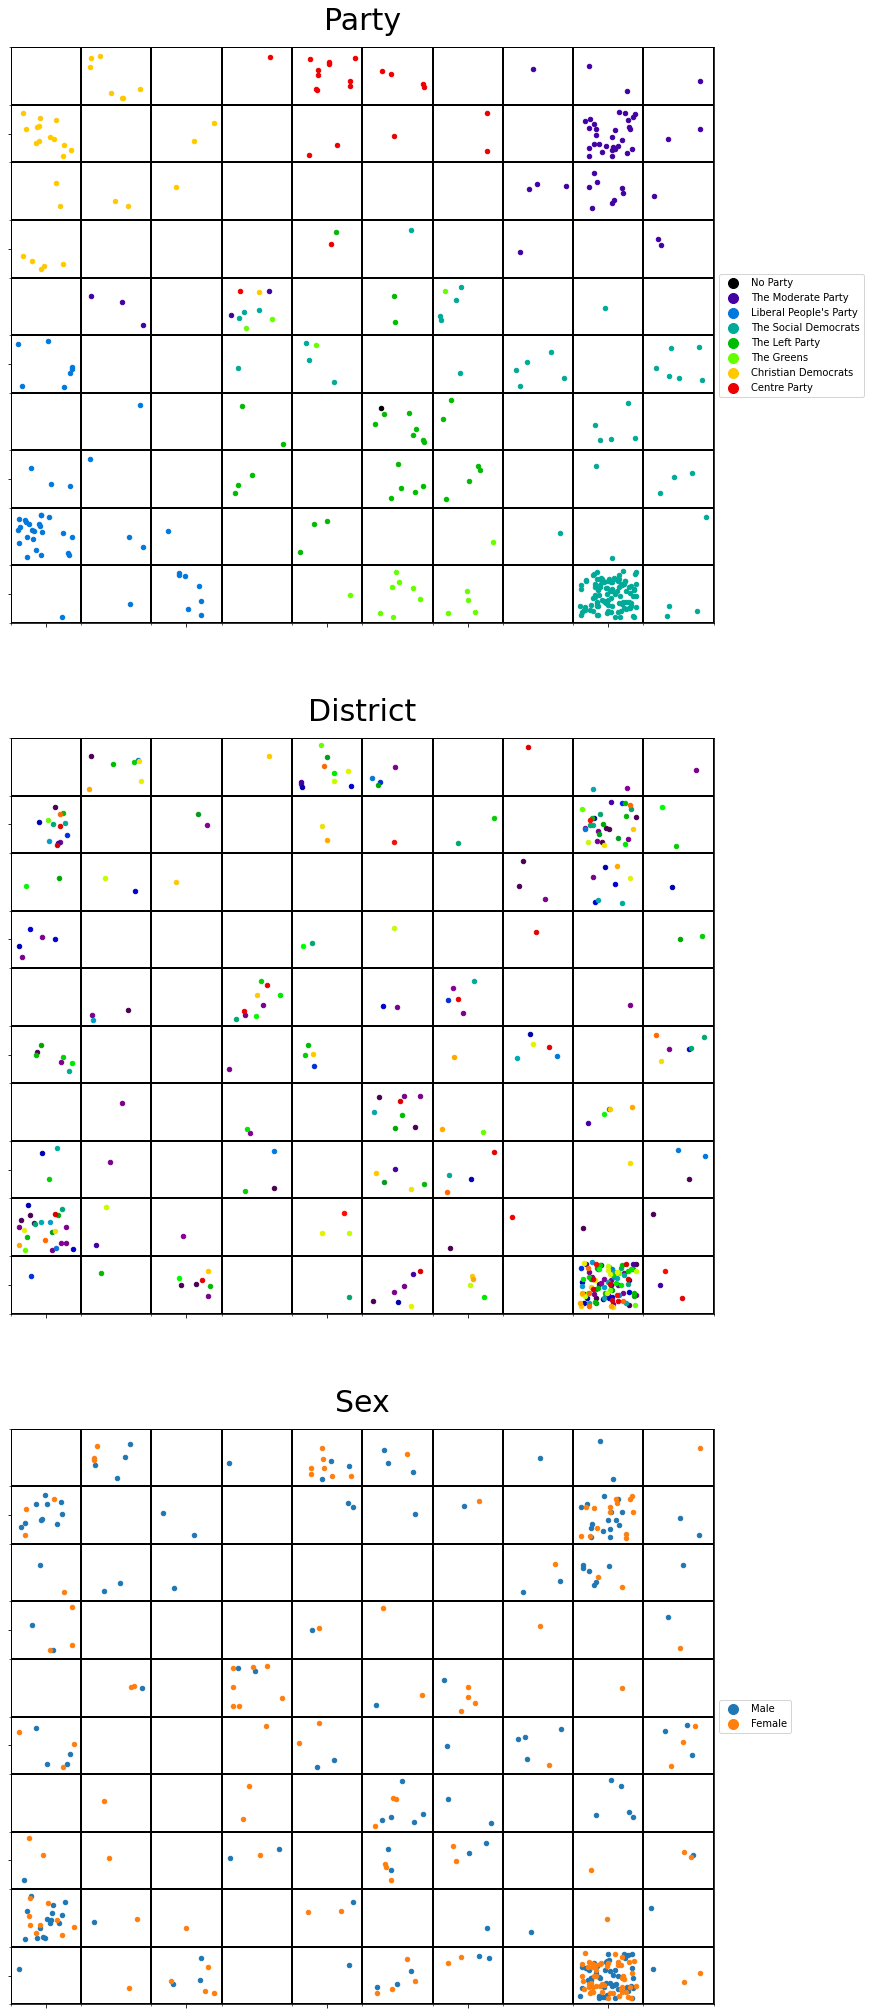

In [4]:
def noisy_index(d, noise=0.4):
    return d.astype(float) + np.random.uniform(-noise, noise, size=d.shape)

_, axes = subplots(mp_attrs.shape[1], 1, size=figsize(6, 3))

cmap_default = plt.get_cmap('tab10')
cmap = plt.get_cmap('nipy_spectral')

grid = np.full(gridsize, -1)
grid_x, grid_y = np.mgrid[:gridsize[1], :gridsize[0]]

for attr, attr_name, val_names, ax in zip(mp_attrs.T, mp_attr_names, mp_val_names, axes):
    for val in np.unique(attr):
        x, y = np.unravel_index(scores[attr == val], gridsize)

        if len(val_names) == 2:
            color = cmap_default(val)
        else:
            color = cmap((cmap.N // len(val_names)) * val)

        ax.scatter(noisy_index(x), noisy_index(y),
                   s=20, color=color, alpha=1,
                   label=val_names[val])

    # title
    ax.set_title(attr_name, fontsize=30, y=1.02)

    # gridlines
    ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)

    ax.set_xlim([-0.5, 9.5])
    ax.set_ylim([-0.5, 9.5])

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

    # legend
    bbox = ax.get_position()
    ax.set_position([bbox.x0, bbox.y0, bbox.width * 0.7, bbox.height])

    if len(val_names) < 10:
        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        for handle in legend.legendHandles:
            handle.set_sizes([100])

plt.savefig('../figures/mp_grids.svg')

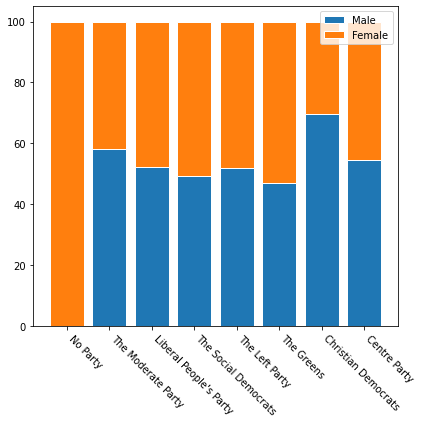

In [5]:
m_bars = []
f_bars = []

parties = np.unique(party)
num_parties = len(parties)

for p in np.unique(party):
    s = sex[np.where(party == p)]

    perc_f = np.count_nonzero(s) / len(s)
    perc_m = 1 - perc_f

    m_bars.append(perc_m * 100)
    f_bars.append(perc_f * 100)

_, ax = subplots(1, 1)

ax.bar(range(num_parties), m_bars, edgecolor='w', label="Male")
ax.bar(range(num_parties), f_bars, bottom=m_bars, edgecolor='w', label="Female")

ax.set_xticks(range(num_parties))
ax.set_xticklabels(mp_val_names[mp_attr_names.index('Party')],
                   rotation=-45, ha='left')

ax.legend()

plt.tight_layout()

plt.savefig('../figures/party_sex_distribution.svg')